In [16]:
# %%
import matplotlib.pyplot as plt
import os
import math
import numpy as np
import pandas as pd
import re
import sys

from scipy.stats import spearmanr
#import skimage

import time
import torch
import torch.hub
import torch.nn

import random
import pickle
import seaborn as sns

# import self-defined MB-SupCon module
from mbsupcon_cont import MbSupConContModel

# %%
print(torch.cuda.is_available())
print(torch.cuda.current_device())
print(torch.cuda.device(0))
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

# %%
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

True
0
1
Tesla V100-PCIE-32GB


In [17]:
class grouped_boxplot():
    def __init__(self, covariate, rmse_embedding_dict_3_methods_list, rmse_original_dict_list, 
                 omics_name_list=['microbiome', 'metabolome'], 
                 weight_methods_list=['linear', 'exponential', 'negative-log'],
                 predict_methods_list=['elasticnet', 'svr', 'rf', 'xgboost']):
        self.covariate = covariate
        self.rmse_embedding_3_methods_dict = {}
        self.rmse_original_3_methods_dict = {}
        for i, OMICS in enumerate(omics_name_list):
            self.rmse_embedding_3_methods_dict[OMICS] = rmse_embedding_dict_3_methods_list[i]
            self.rmse_original_3_methods_dict[OMICS] = rmse_original_dict_list[i]
        self.omics_name_list = omics_name_list
        self.weight_methods_list = weight_methods_list
        self.predict_methods_list = predict_methods_list

    def _generate_plotting_df(self, rmse_embedding_dict_3_methods, rmse_original_dict):
        rmse_boxplot_list = []
        data_x_name = []
        for weight_method in self.weight_methods_list:
            for i, method in enumerate(self.predict_methods_list):
                testing_idx = (slice(None),) + (1,) # val: 0; test: 1
                rmse_array_embedding = rmse_embedding_dict_3_methods[weight_method][self.covariate][method][testing_idx] 
                rmse_boxplot_list.extend(rmse_array_embedding)
                if weight_method == 'linear':
                    rmse_boxplot_list.extend(rmse_original_dict[self.covariate][method][:,1])
                    data_x_name.extend(np.repeat([weight_method.capitalize(), 'Original'], rmse_array_embedding.shape[0]))
                else:
                    data_x_name.extend(np.repeat([weight_method.capitalize()], rmse_array_embedding.shape[0]))
        
        prediction_method_array = np.concatenate([np.repeat(self.predict_methods_list, rmse_array_embedding.shape[0]*2),
                                                np.tile(np.repeat(self.predict_methods_list, rmse_array_embedding.shape[0]),
                                                        len(self.weight_methods_list)-1)])
        rmse_df_all = pd.DataFrame({'RMSE': rmse_boxplot_list,
                        'Prediction_method': prediction_method_array,
                        'Data_X': data_x_name})
        rmse_df_all['Prediction_method'] = rmse_df_all['Prediction_method'].str.upper()
        return rmse_df_all
    
    def _setBold(self, txt): 
        return f"$\\bf{{{txt}}}$"

    def plot(self, save_folder, title, fontsize=20, loc=0, color_palette=['red', 'pink', 'lightblue', 'lightgreen']):
        import seaborn as sns
        import matplotlib.pyplot as plt
        import matplotlib
        matplotlib.rcParams['pdf.fonttype'] = 42
        matplotlib.rcParams['ps.fonttype'] = 42

        OMICS_1, OMICS_2 = self.omics_name_list
        rmse_df_all_1 = self._generate_plotting_df(self.rmse_embedding_3_methods_dict[OMICS_1], self.rmse_original_3_methods_dict[OMICS_1])
        rmse_df_all_2 = self._generate_plotting_df(self.rmse_embedding_3_methods_dict[OMICS_2], self.rmse_original_3_methods_dict[OMICS_2])

        fig, (ax1, ax2) = plt.subplots(1,2,figsize=(32,8), sharey=True)
        plt.tight_layout()
        hue_order = ['Original'] + [wm.capitalize() for wm in self.weight_methods_list]
        sns.boxplot(x='Prediction_method', y='RMSE', data=rmse_df_all_1, hue='Data_X', 
                        notch=True, palette=color_palette, width=0.7, showfliers = False,
                        hue_order=hue_order, ax=ax1)
        sns.stripplot(y='RMSE', x='Prediction_method', data=rmse_df_all_1, hue='Data_X',
                        jitter=True, dodge=True, marker='o', color='black',
                        hue_order=hue_order, ax=ax1)
        title_all1 = f'{title} Omics-1'
        ax1.set_title('{}\nCovariate: {}'.format(self._setBold(title_all1), self.covariate), fontsize=fontsize)
        ax1.tick_params(axis='both', labelsize=fontsize)
        ax1.xaxis.get_label().set_fontsize(fontsize)
        ax1.yaxis.get_label().set_fontsize(fontsize)
        ax1.set_xlabel('Prediction method')
        handles, labels = ax1.get_legend_handles_labels()
        ax1.legend(handles[:4], labels[:4], loc=loc, fontsize=25)

        sns.boxplot(x='Prediction_method', y='RMSE', data=rmse_df_all_2, hue='Data_X', 
                        notch=True, palette=color_palette, width=0.7, showfliers = False,
                        hue_order=hue_order, ax=ax2)
        sns.stripplot(y='RMSE', x='Prediction_method', data=rmse_df_all_2, hue='Data_X',
                        jitter=True, dodge=True, marker='o', color='black',
                        hue_order=hue_order, ax=ax2)
        title_all2 = f'{title} Omics-2'
        ax2.set_title('{}\nCovariate: {}'.format(self._setBold(title_all2), self.covariate), fontsize=fontsize)
        ax2.tick_params(axis='both', labelsize=fontsize)
        ax2.xaxis.get_label().set_fontsize(fontsize)
        ax2.set_xlabel('Prediction method')
        ax2.set_ylabel('')
        handles, labels = ax2.get_legend_handles_labels()
        ax2.legend(handles[:4], labels[:4], loc=loc, fontsize=25)
        
        figure_save_folder = os.path.join(save_folder, 'figures')
        os.makedirs(figure_save_folder, exist_ok=True)
        plt.savefig(os.path.join(figure_save_folder, f'{OMICS_1}_vs_{OMICS_2}_{self.covariate}_all_seeds_rmse_boxplot.pdf'),
                    bbox_inches='tight')
        
        plt.show()

In [18]:
embedding_dim_list = [10, 20, 40]
weighting_method_list = ['linear', 'exponential', 'negative-log']
omics_data_list = ['microbiome', 'metabolome']
predict_methods_list = ['elasticnet', 'svr', 'rf', 'xgboost']
covariate_list = ['Age']


In [19]:
dim_results_dict = {}
for EMBEDDING_DIM in embedding_dim_list:
    dim_results_dict[EMBEDDING_DIM] = {}
    for WEIGHTING_METHOD in weighting_method_list:
        # print("========================================================")
        # print('EMBEDDING_DIM:', EMBEDDING_DIM)
        # print('WEIGHTING_METHOD:', WEIGHTING_METHOD)
        # print("========================================================")

        SAVE_FOLDER = f'./emb_dim-{EMBEDDING_DIM}/{WEIGHTING_METHOD}_weights'
        dim_results_dict[EMBEDDING_DIM][WEIGHTING_METHOD] = {}

        for OMICS in omics_data_list:
            # print("========================================================")
            # print(f'Omics data: {OMICS}')
            # print("========================================================")
            # print("----------------------------------------------------------")
            # print('Average RMSE of prediction based on original data:')
            dim_results_dict[EMBEDDING_DIM][WEIGHTING_METHOD][OMICS] = {'original':{}, 'embedding':{}}
            ## Original
            with open(os.path.join(SAVE_FOLDER, f'{OMICS}_rmse_original_dict.pkl'), 'rb') as f:
                omics_rmse_original_dict = pickle.load(f)

            dim_results_dict[EMBEDDING_DIM][WEIGHTING_METHOD][OMICS]['original']['multi_seeds'] = omics_rmse_original_dict

            omics_mean_rmse_original_df_dict = dict()
            for covariate in covariate_list:
                omics_mean_rmse_original_df_dict[covariate] = pd.DataFrame(index=predict_methods_list,
                                                                           columns=['Validation', 'Testing'])
                for method in predict_methods_list:
                    omics_mean_rmse_original_df_dict[covariate].loc[method,:] = \
                        np.mean(omics_rmse_original_dict[covariate][method], axis=0)
                    
            # for covariate in covariate_list:
            #     print('Covariate:', covariate)
            #     display(omics_mean_rmse_original_df_dict[covariate].style.format(formatter="{:.4f}"))
            dim_results_dict[EMBEDDING_DIM][WEIGHTING_METHOD][OMICS]['original']['mean_df'] = omics_mean_rmse_original_df_dict
            ## Embedding
            # print("----------------------------------------------------------")
            # print('Average RMSE of prediction based on embeddings:')
            with open(os.path.join(SAVE_FOLDER, f'{OMICS}_rmse_embedding_dict.pkl'), 'rb') as f:
                omics_rmse_embedding_dict = pickle.load(f)

            dim_results_dict[EMBEDDING_DIM][WEIGHTING_METHOD][OMICS]['embedding']['multi_seeds'] = omics_rmse_embedding_dict

            omics_mean_rmse_embedding_df_dict = dict()
            for covariate in covariate_list:
                omics_mean_rmse_embedding_df_dict[covariate] = pd.DataFrame(index=predict_methods_list,
                                                                            columns=['Validation', 'Testing'])
                for method in predict_methods_list:
                    omics_mean_rmse_embedding_df_dict[covariate].loc[method,:] = \
                        np.mean(omics_rmse_embedding_dict[covariate][method], axis=0)
                    
            # for covariate in covariate_list:
            #     print('Covariate:', covariate)
            #     display(omics_mean_rmse_embedding_df_dict[covariate].style.format(formatter="{:.4f}"))
            dim_results_dict[EMBEDDING_DIM][WEIGHTING_METHOD][OMICS]['embedding']['mean_df'] = omics_mean_rmse_embedding_df_dict
            # print("----------------------------------------------------------")
            # grouped_boxplot_rmse(covariate=covariate, save_folder=SAVE_FOLDER,
            #         rmse_embedding_dict=omics_rmse_embedding_dict, 
            #         rmse_original_dict=omics_rmse_original_dict, omics=OMICS,
            #         title=f'Simulation Study - RMSE on testing data ({OMICS})', loc=1)

EMBEDDING_DIM: 10
--------------------------------------------------------
COVARIATE: Age
--------------------------------------------------------
OMICS: microbiome


EMBEDDING_DIM: 10
--------------------------------------------------------
COVARIATE: Age
--------------------------------------------------------
OMICS: metabolome


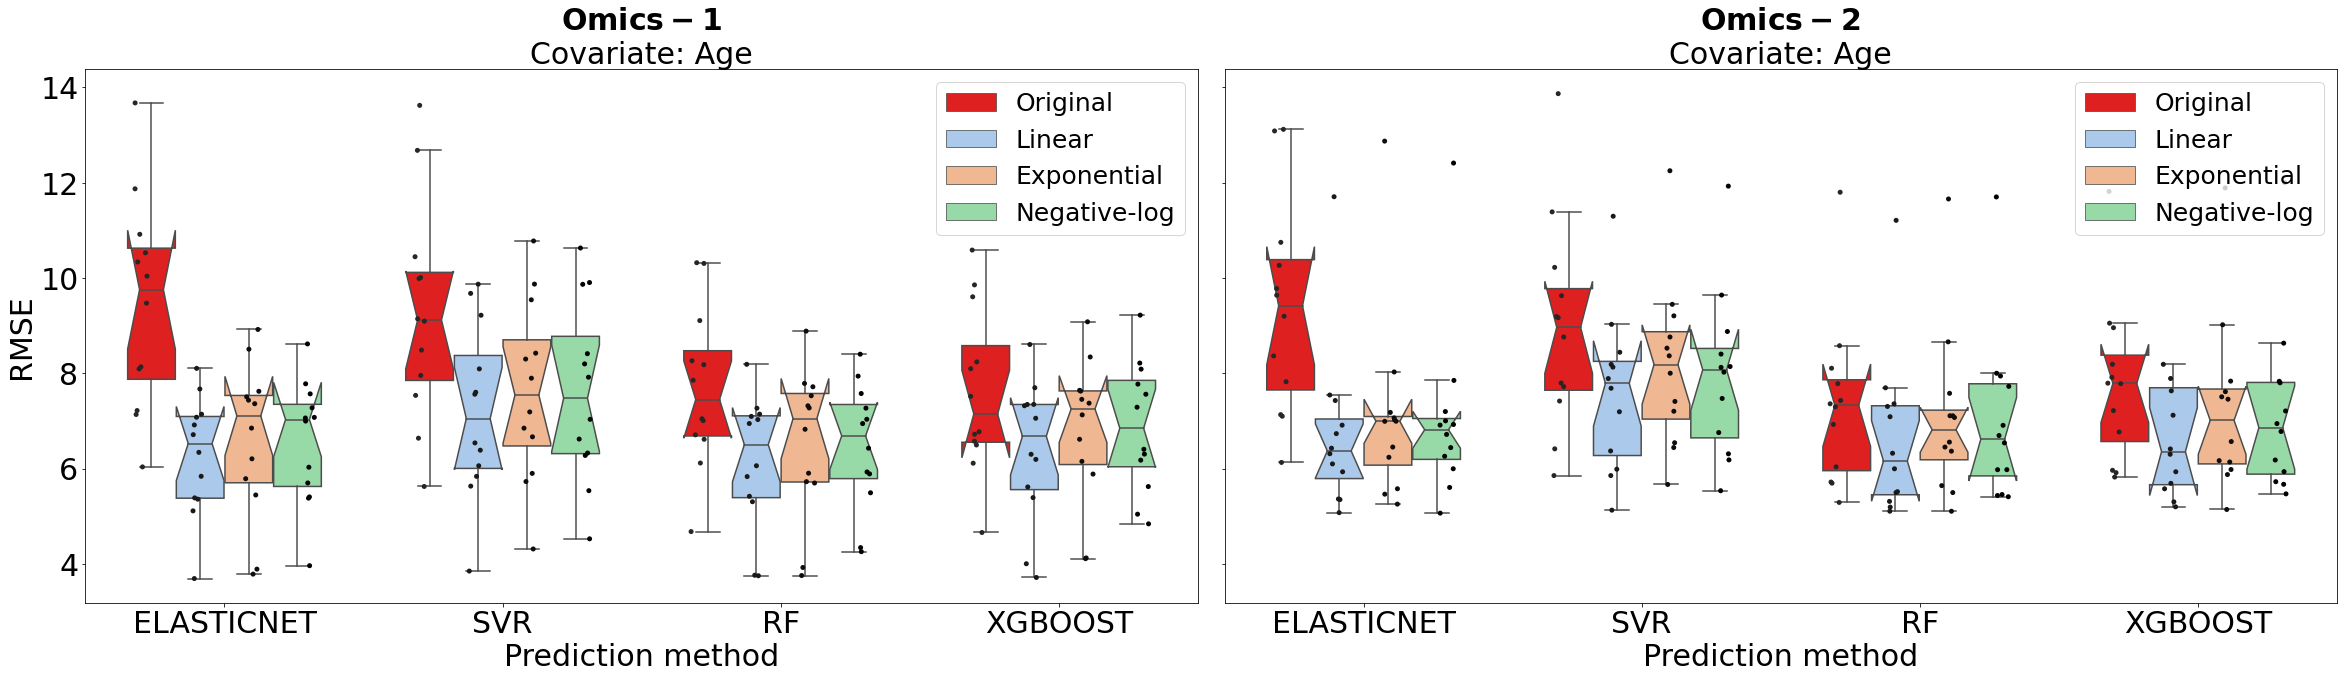

EMBEDDING_DIM: 20
--------------------------------------------------------
COVARIATE: Age
--------------------------------------------------------
OMICS: microbiome


EMBEDDING_DIM: 20
--------------------------------------------------------
COVARIATE: Age
--------------------------------------------------------
OMICS: metabolome


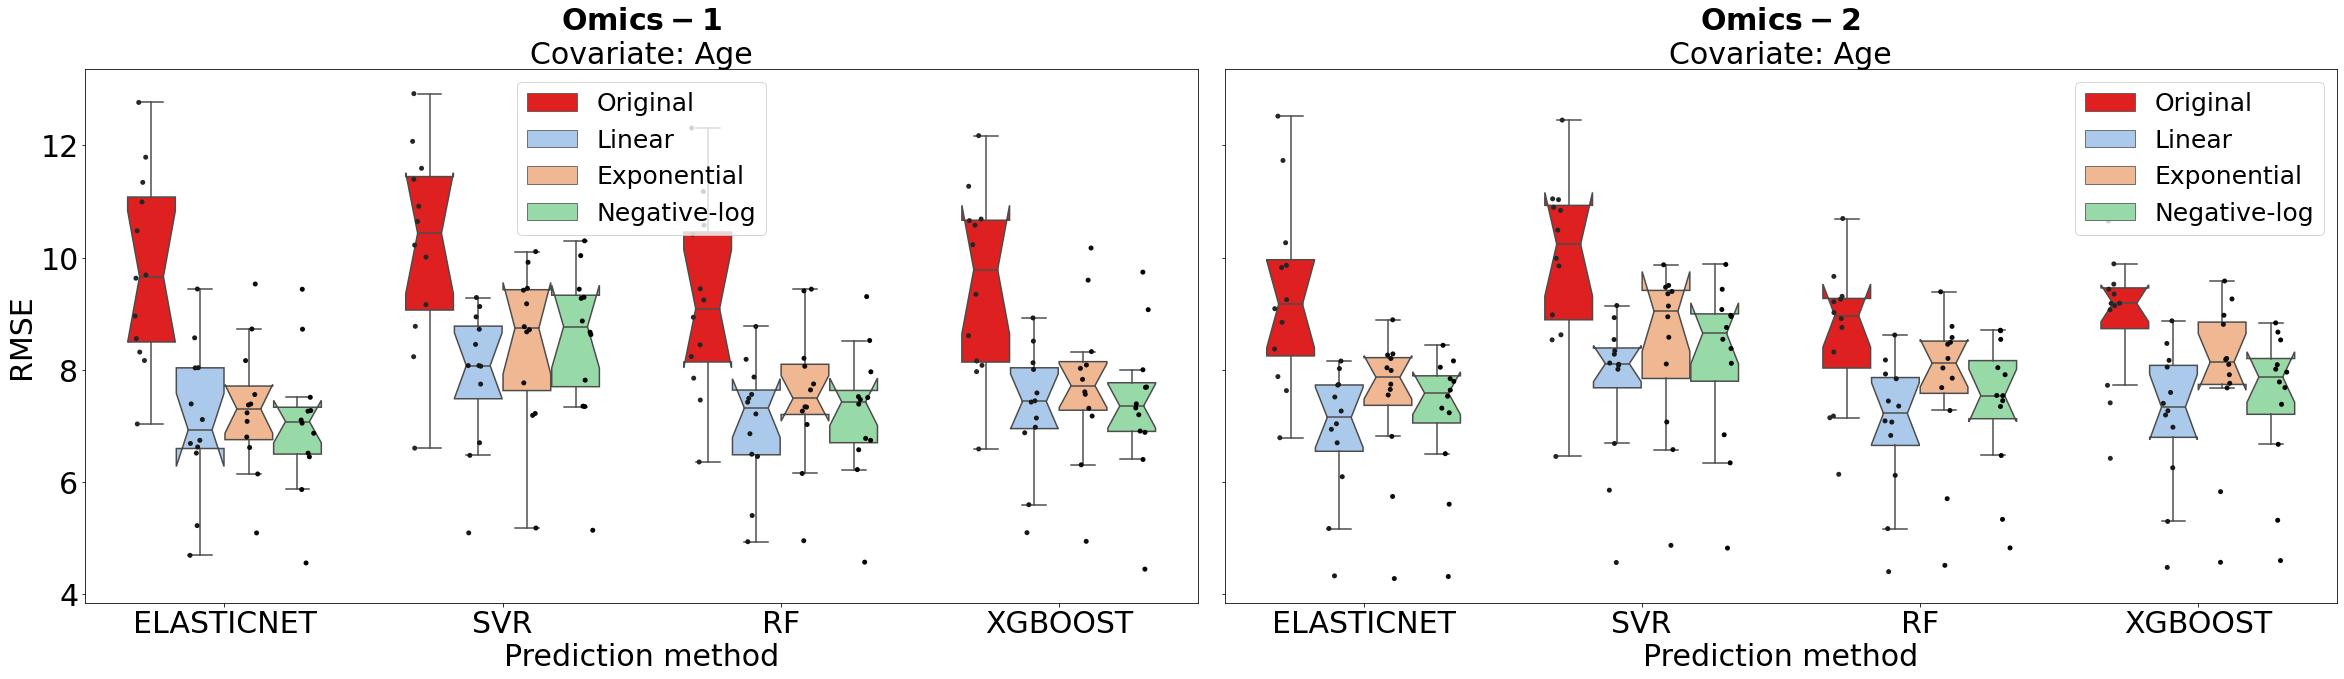

EMBEDDING_DIM: 40
--------------------------------------------------------
COVARIATE: Age
--------------------------------------------------------
OMICS: microbiome


EMBEDDING_DIM: 40
--------------------------------------------------------
COVARIATE: Age
--------------------------------------------------------
OMICS: metabolome


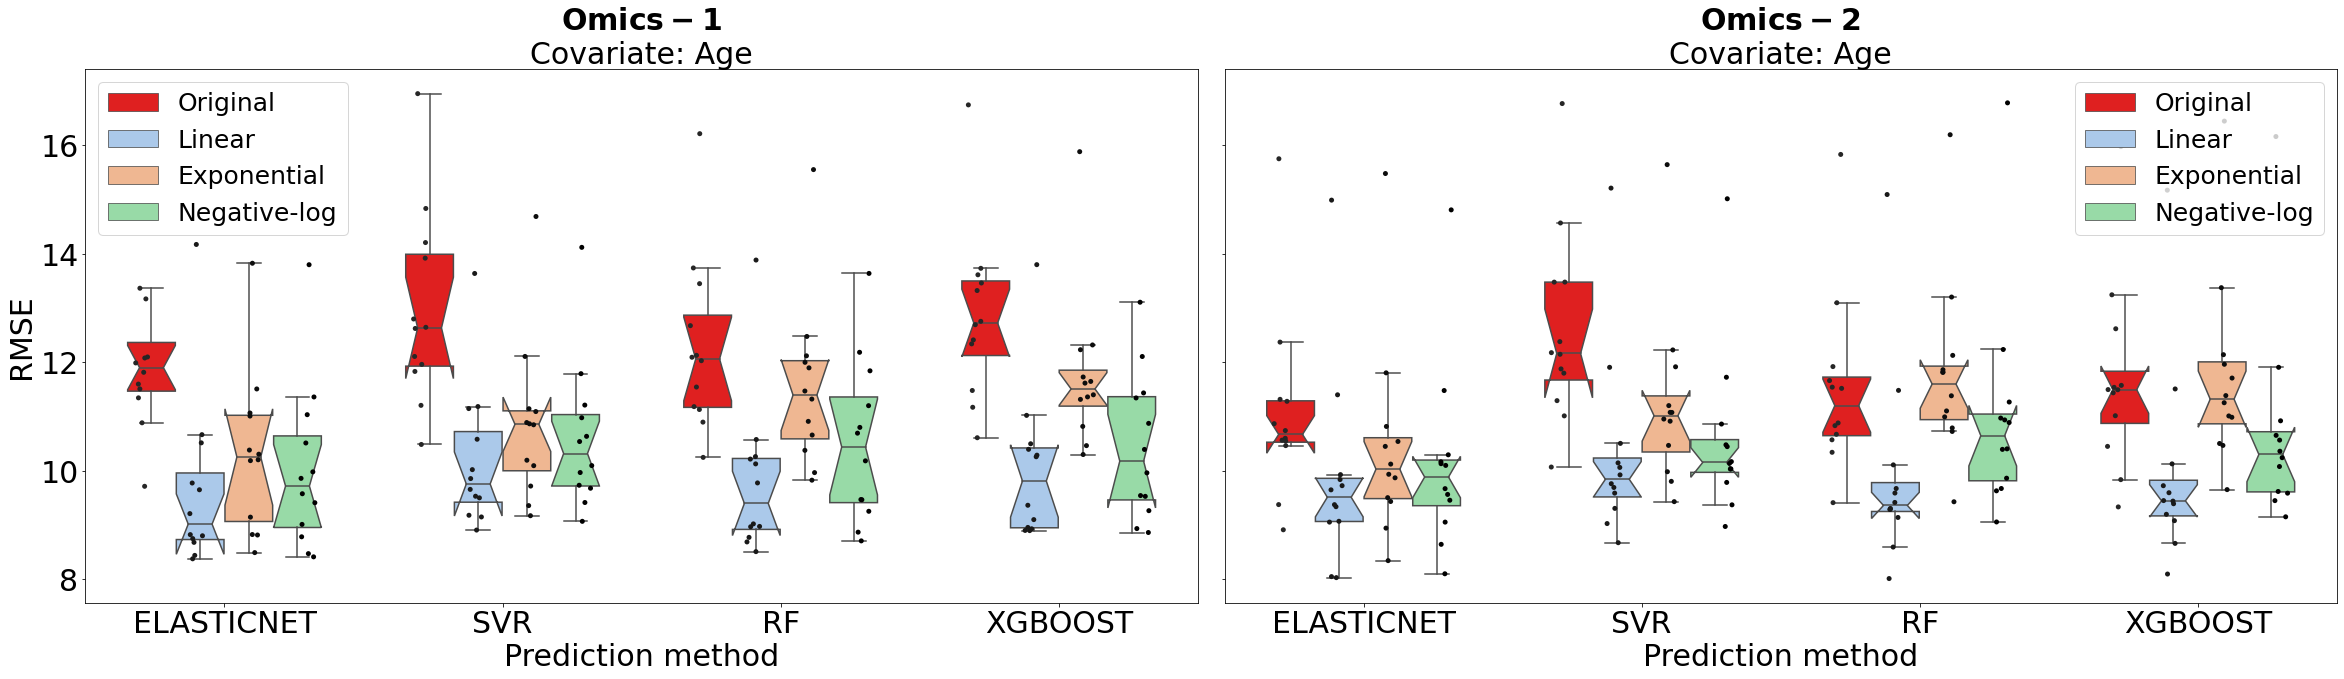

In [20]:
df_display_dict = {}

for EMBEDDING_DIM in embedding_dim_list:
    df_display_dict[EMBEDDING_DIM] = {}
    for COVARIATE in covariate_list:
        rmse_embedding_dict_3_methods_list, rmse_original_dict_list = [], []
        for OMICS in omics_data_list:
            print("========================================================")
            print('EMBEDDING_DIM:', EMBEDDING_DIM)
            print("--------------------------------------------------------")
            print('COVARIATE:', COVARIATE)
            print("--------------------------------------------------------")
            print('OMICS:', OMICS)
            print("========================================================")
            df_display_original = dim_results_dict[EMBEDDING_DIM]['linear'][OMICS]['original']['mean_df'][COVARIATE]

            df_display_embedding = pd.concat(
                                            [dim_results_dict[EMBEDDING_DIM][weighting_method_list[0]][OMICS]['embedding']['mean_df'][COVARIATE],
                                            dim_results_dict[EMBEDDING_DIM][weighting_method_list[1]][OMICS]['embedding']['mean_df'][COVARIATE],
                                            dim_results_dict[EMBEDDING_DIM][weighting_method_list[2]][OMICS]['embedding']['mean_df'][COVARIATE]],
                                            axis=1
                                            )
            df_display = pd.concat([df_display_original, df_display_embedding], axis=1)
            df_display.columns = pd.MultiIndex.from_product([['Original', 'Embedding: linear', 'Embedding: exponential', 'Embedding: negative-log'], 
                                                            ['Validation', 'Testing']])
            df_display_dict[EMBEDDING_DIM][OMICS] = df_display
            display(df_display.style.format(formatter="{:.4f}"))

            rmse_embedding_dict_3_methods, rmse_original_dict = {}, {COVARIATE: {}}
            for WEIGHTING_METHOD in weighting_method_list:
                rmse_embedding_dict_3_methods[WEIGHTING_METHOD] = {COVARIATE: {}}
                for method in predict_methods_list:
                    rmse_embedding_dict_3_methods[WEIGHTING_METHOD][COVARIATE][method] = \
                        dim_results_dict[EMBEDDING_DIM][WEIGHTING_METHOD][OMICS]['embedding']['multi_seeds'][COVARIATE][method]
                    rmse_original_dict[COVARIATE][method] = dim_results_dict[EMBEDDING_DIM]['linear'][OMICS]['original']['multi_seeds'][COVARIATE][method]
            rmse_embedding_dict_3_methods_list.append(rmse_embedding_dict_3_methods)
            rmse_original_dict_list.append(rmse_original_dict)

        grouped_boxplot_sidebyside = grouped_boxplot(COVARIATE, rmse_embedding_dict_3_methods_list, rmse_original_dict_list)   
        grouped_boxplot_sidebyside.plot(save_folder=f'./emb_dim-{EMBEDDING_DIM}',
                                        title=f'', loc=0, fontsize=30,
                                        color_palette=['red'] + sns.color_palette("pastel")[:3])